# Assignment description

Build synthetic scale-free networks according to the BA model. Consider $m$ new connections for each node inserted. Calculate empiracally properties like CC and APL. Compare the obtained results for networks of same size generated by Poisson model and WS model. What do you observe?

In [1]:
%config Completer.use_jedi = False

In [2]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Graph parameters

We're going to build some Erdos-Renyi (ER) models varying its parameters. When we fix a connection probability we're also fixing its degree. So we'll create some realizations for each combination of n and z.

In [3]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]
avg_degree_array = [0, 0.5, 0.9, 1, 2, 3, 4, "2log"] #np.arange(0, 3.2, 0.2)
ensemble_size = 2

In [4]:
len(nodes_array) * len(avg_degree_array ) * ensemble_size

96

In [5]:
def find_percolation_threshold(n = 1000, threshold = 0.5, step = 0.2):
    graphs_dict = dict()
    avg_degree = 0
    while True:
        nodes = n
        graphs_dict[avg_degree] = dict()

        probability = avg_degree/nodes        
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_dict[avg_degree][probability] = graph
        giant = graph.clusters().giant()
        graphs_dict[avg_degree][probability]["giant"] = giant
        giant_fraction = giant.vcount()/n
        avg_degree += step
        if giant_fraction > threshold:
            return graphs_dict

percolations = find_percolation_threshold()

In [6]:
percolations

{0: {0.0: <igraph.Graph at 0x211447b97c0>},
 0.2: {0.0002: <igraph.Graph at 0x211447b98b0>},
 0.4: {0.0004: <igraph.Graph at 0x211447b9a90>},
 0.6000000000000001: {0.0006000000000000001: <igraph.Graph at 0x211447b9c70>},
 0.8: {0.0008: <igraph.Graph at 0x211447b9e50>},
 1.0: {0.001: <igraph.Graph at 0x21144897130>},
 1.2: {0.0012: <igraph.Graph at 0x21144897310>},
 1.4: {0.0014: <igraph.Graph at 0x211448974f0>},
 1.5999999999999999: {0.0015999999999999999: <igraph.Graph at 0x211448976d0>}}

## Graph building

### Poisson networks

In [7]:
# %%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, avg_degree_array])

poisson_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    
    if network_property[1] in ["log", "2log"]:
        degree = 2*np.round(np.log(nodes), 2)
        key = str(nodes) + '_nodes__' + network_property[1] + "_degree"
    else:
        degree = network_property[1]
        key = str(nodes) + '_nodes__' + str(degree) + "_degree"
    probability = degree/nodes
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_list.append(graph)
    
    poisson_graphs[key] = dict()
    poisson_graphs[key]['graphs'] = graphs_list
    poisson_graphs[key]["nodes"] = nodes
    poisson_graphs[key]["degree"] = network_property[1]
    poisson_graphs[key]["probability"] = probability    

In [67]:
%%time
# Calculate some metrics for each graph realization

nodes_number = list()
edges_number = list()
degree_number = list()
clustering_coefficient = list()
avg_path_length = list()
probabilities_values = list()

for params in poisson_graphs.keys():
    for graph in poisson_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_undirected())
        avg_path_length.append(graph.average_path_length())
        edges_number.append(len(graph.get_edgelist()))
        nodes_number.append(poisson_graphs[params]["nodes"])     
        probabilities_values.append(poisson_graphs[params]["probability"])
        degree_number.append(poisson_graphs[params]["degree"])
        

Wall time: 2min 2s


In [68]:
poisson_analysis = pd.DataFrame()

poisson_analysis["nodes_number"] = nodes_number
poisson_analysis["edges_number"] = edges_number
poisson_analysis["degree"] = degree_number
poisson_analysis["probability"] = probabilities_values
poisson_analysis["clustering_coefficient"] = clustering_coefficient
poisson_analysis["avg_path_length"] = avg_path_length

poisson_analysis.head()

,nodes_number,edges_number,degree,probability,clustering_coefficient,avg_path_length
0,1000,0,0,0.0000,NaN,NaN
1,1000,0,0,0.0000,NaN,NaN
2,1000,238,0.5,0.0005,0.0,2.296099
3,1000,236,0.5,0.0005,0.0,1.785377
4,1000,476,0.9,0.0009,0.0,5.633852


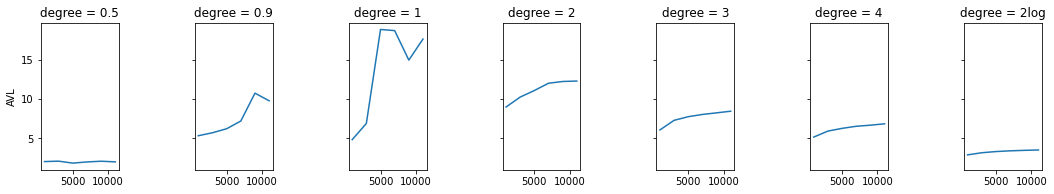

In [77]:
df_plot = poisson_analysis.pivot_table(index = ["nodes_number", "degree"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

degree_values = df_plot["degree"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(degree_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(degree_values)):
    # Filter the dataset
    data = df_plot[df_plot["degree"].isin([degree_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"degree = {degree_values[i]}")
    
_ = ax[0].set_ylabel("AVL")
# _ = ax2.set_ylabel("log(n)")


### Barabasi-Albert networks

In [11]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]
ensemble_size = 2
m_number = np.arange(1, 6, 1)

In [12]:
%%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, m_number])

barabasi_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    m_value = int(network_property[1])
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Barabasi(n = nodes, m = m_value)

        graphs_list.append(graph)

    key = str(nodes) + "_nodes__" + str(m_value) + "_m"
    barabasi_graphs[key] = dict()
    barabasi_graphs[key]['graphs'] = graphs_list
    barabasi_graphs[key]["nodes"] = nodes
    barabasi_graphs[key]["m"] = m_value

Wall time: 361 ms


In [13]:
%%time
clustering_coefficient = list()
avg_path_length = list()
nodes_number = list()
edges_number = list()
m_values = list()

for params in barabasi_graphs.keys():
    for graph in barabasi_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_undirected())
        avg_path_length.append(graph.average_path_length())
        nodes_number.append(barabasi_graphs[params]["nodes"])
        m_values.append(barabasi_graphs[params]["m"]) 
        edges_number.append(len(graph.get_edgelist()))
        

Wall time: 2min 2s


In [14]:
barabasi_analysis = pd.DataFrame()
barabasi_analysis["nodes_number"] = nodes_number
barabasi_analysis["m_values"] = m_values
barabasi_analysis["avg_path_length"] = avg_path_length
barabasi_analysis["clustering_coefficient"] = clustering_coefficient

barabasi_analysis.fillna(0, inplace = True)

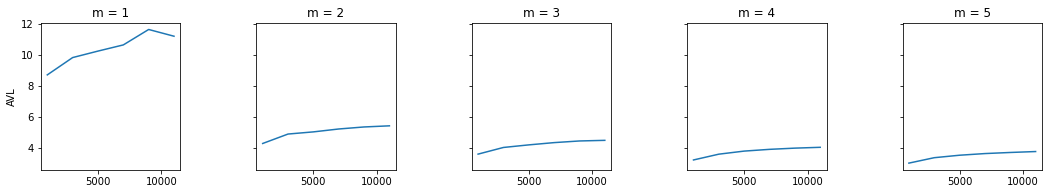

In [63]:
df_plot = barabasi_analysis.pivot_table(index = ["nodes_number", "m_values"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

m_values = df_plot["m_values"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(m_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(m_values)):
    # Filter the dataset
    data = df_plot[df_plot["m_values"].isin([m_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"m = {m_values[i]}")
    
_ = ax[0].set_ylabel("AVL")
# _ = ax2.set_ylabel("log(n)")


### Watts-Strogatz networks

In [31]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]

ensemble_size = 2
steps_number = np.arange(1, 6, 1)
rewiring_probabilities = np.arange(0, 0.3, 0.05)

In [39]:
%%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, steps_number, rewiring_probabilities])

watts_strogatz_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    steps = int(network_property[1])
    rewiring = network_property[2]
    
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Watts_Strogatz(dim = 1, size = nodes, nei = steps, p = rewiring)

        graphs_list.append(graph)

    key = str(nodes) + "_nodes__" + str(steps) + "_nei__" + str(rewiring) + "_rewiring_prob"
    watts_strogatz_graphs[key] = dict()
    watts_strogatz_graphs[key]['graphs'] = graphs_list
    watts_strogatz_graphs[key]["nodes"] = nodes
    watts_strogatz_graphs[key]["rewiring_prob"] = rewiring

Wall time: 1.67 s


In [40]:
%%time
clustering_coefficient = list()
avg_path_length = list()
nodes_number = list()
edges_number = list()
rewiring_prob_values = list()

for params in watts_strogatz_graphs.keys():
    for graph in watts_strogatz_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_undirected())
        avg_path_length.append(graph.average_path_length())
        nodes_number.append(watts_strogatz_graphs[params]["nodes"])
        rewiring_prob_values.append(watts_strogatz_graphs[params]["rewiring_prob"]) 
        edges_number.append(len(graph.get_edgelist()))
        
watts_strogatz_analysis = pd.DataFrame()
watts_strogatz_analysis["nodes_number"] = nodes_number
watts_strogatz_analysis["rewiring_prob"] = rewiring_prob_values
watts_strogatz_analysis["avg_path_length"] = avg_path_length
watts_strogatz_analysis["clustering_coefficient"] = clustering_coefficient

watts_strogatz_analysis.fillna(0, inplace = True)

Wall time: 10min 31s


In [42]:
watts_strogatz_analysis.pivot_table(index = ["nodes_number", "rewiring_prob"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   )

mean                       
                           avg_path_length clustering_coefficient
nodes_number rewiring_prob                                       
1000         0.00               114.552953               0.481905
             0.05                14.609165               0.345620
             0.10                 9.294783               0.250418
             0.15                 7.699625               0.173462
             0.20                 6.960148               0.121564
             0.25                 6.253804               0.082948
3000         0.00               342.885962               0.481905
             0.05                17.151697               0.344992
             0.10                11.593251               0.246422
             0.15                 9.190284               0.173602
             0.20                 8.256806               0.119021
             0.25                 7.490995               0.081432
5000         0.00               571.219244               0.481905
             0.05                18.180925               0.346637
             0.10                12.215191               0.247677
             0.15                10.129384               0.172319
             0.20                 9.073927               0.121058
             0.25                 8.215306               0.080274
7000         0.00               799.552565               0.481905
             0.05                18.998881               0.347268
             0.10                12.726942               0.246691
             0.15                10.663906               0.175084
             0.20                 9.247945               0.119311
             0.25                 8.363060               0.080088
9000         0.00              1027.885876               0.481905
             0.05                18.899460               0.348329
             0.10                13.623179               0.246481
             0.15                10.988381               0.172231
             0.20                 9.448451               0.118588
             0.25                 8.783984               0.080034
11000        0.00              1256.219202               0.481905
             0.05                21.371999               0.348340
             0.10                14.063825               0.246687
             0.15                11.025885               0.172677
             0.20                 9.910452               0.118429
             0.25                 8.975446               0.079929

In [45]:
df_plot = watts_strogatz_analysis.pivot_table(index = ["nodes_number", "rewiring_prob"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

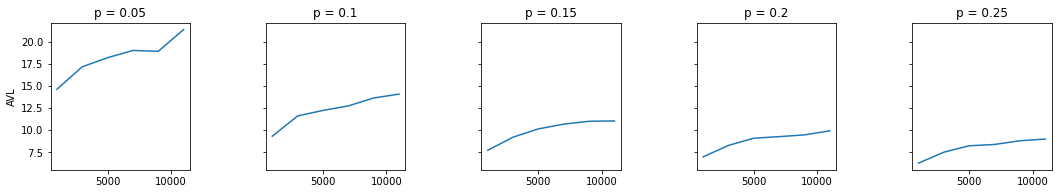

In [56]:
rewiring_values = df_plot["rewiring_prob"].unique()[1:]

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(rewiring_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(rewiring_values)):
    # Filter the dataset
    data = df_plot[df_plot["rewiring_prob"].isin([rewiring_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"p = {np.round(rewiring_values[i], 2)}")
    
_ = ax[0].set_ylabel("AVL")
# _ = ax2.set_ylabel("log(n)")


In [27]:
barabasi_analysis.shape

(60, 4)